In [4]:
import numpy as np
import pandas as pd
from scipy.stats import mode
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import classification_report

from sklearn import svm
from sklearn.svm import SVC
from sklearn.svm import SVR
from sklearn import preprocessing
from sklearn import linear_model


%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Modelo de evolución de un disco protoplanetario en un sistema planetario
### A continuación se importan los datos de la evolución de un disco de gas y polvo que rodea una estrella central y la evolución de este en un sistema planetario.

### Preprocesamiento de los datos

In [31]:
high = pd.read_csv('datos/highp_finalresults.csv')
low = pd.read_csv('datos/lowp_finalresults.csv')

num_planetas_high = high.groupby(['ident']).size().get_values()
num_planetas_low = low.groupby(['ident']).size().get_values()

masa_plan_high = high.groupby(['ident'])['emepla(i)/emet'].sum().get_values()
masa_plan_low = low.groupby(['ident'])['emepla(i)/emet'].sum().get_values()

efic_masa_high = masa_plan_high/high.groupby(['ident'])['emed'].mean().get_values()
efic_masa_low = masa_plan_low/low.groupby(['ident'])['emed'].mean().get_values()

X_low = low.drop(['a(i)','emegas(i)','emepla(i)/emet','rplanet(i)/radtie'],inplace=False,axis=1).groupby(['ident']).mean()
X_high = high.drop(['a(i)','emegas(i)','emepla(i)/emet','rplanet(i)/radtie'],inplace=False,axis=1).groupby(['ident']).mean()

scaler = preprocessing.StandardScaler().fit(X_high)
Scale_high = scaler.transform(X_high)
scaler = preprocessing.StandardScaler().fit(X_low)
Scale_low = scaler.transform(X_low)

X_train, X_test, Y_train, Y_test = train_test_split(Scale_high, num_planetas_high, test_size=0.3)

## Modelo de estimación del número de planetas

###  Support Vector Machine con kernel gaussiano
Se exploran parámetros en una escala logarítmica para optimizar el ajuste, para cinco splits diferentes.

In [25]:
mejores_Cs_h = []
mejores_gamma_h = []
scores_h = []

mejores_Cs_l = []
mejores_gamma_l = []
scores_l = []

for i in range(3):
    X_train_h, X_test_h, Y_train_h, Y_test_h = train_test_split(Scale_high, num_planetas_high, test_size=0.3)
    X_train_l, X_test_l, Y_train_l, Y_test_l = train_test_split(Scale_low, num_planetas_low, test_size=0.3)

    C=[0.1, 0.01, 0.001, 0.0001, 0.00001, 1, 5]
    gamma=[0.1, 0.01, 0.001, 0.0001, 0.00001, 1, 10, 100, 1000, 10000]
    sco_h=0
    sco_l=0
    
    for c in C:
        for g in gamma:
            gauss_h = svm.SVC(C=c,kernel='rbf',gamma=g)
            gauss_h.fit(X_train_h,Y_train_h)
            Y_predict_h = gauss_h.predict(X_test_h)
            ii_h = Y_predict_h == Y_test_h
            if sum(ii_h) > sco_h:
                sco_h = sum(ii_h)
                mejor_g_h = g
                mejor_c_h = c
                
            gauss_l = svm.SVC(C=c,kernel='rbf',gamma=g)
            gauss_l.fit(X_train_l,Y_train_l)
            Y_predict_l = gauss_l.predict(X_test_l)
            ii_l = Y_predict_l == Y_test_l
            if sum(ii_l) > sco_l:
                sco_l = sum(ii_l)
                mejor_g_l = g
                mejor_c_l = c
                
    mejores_Cs_h.append(mejor_c_h)
    mejores_gamma_h.append(mejor_g_h)
    scores_h.append(sco_h)
    
    mejores_Cs_l.append(mejor_c_l)
    mejores_gamma_l.append(mejor_g_l)
    scores_l.append(sco_l)
    
bestC_h = mode(mejores_Cs_h)[0][0]
bestG_h = mode(mejores_gamma_h)[0][0]
indices_h = [i for i, x in enumerate(mejores_Cs_h) if x == bestC_h]
mejores_scores_h = [scores_h[i] for i in indices_h]
bestSco_h = mean(mejores_scores_h)

bestC_l = mode(mejores_Cs_l)[0][0]
bestG_l = mode(mejores_gamma_l)[0][0]
indices_l = [i for i, x in enumerate(mejores_Cs_l) if x == bestC_l]
mejores_scores_l = [scores_l[i] for i in indices_l]
bestSco_l = mean(mejores_scores_l)
                
print('HIGH: metodo: SVM rbf', '. average hits:', bestSco_h, '. mejor gamma:', bestG_h, '. mejor C:', bestC_h)
print('LOW: metodo: SVM rbf', '. average hits:', bestSco_l, '. mejor gamma:', bestG_l, '. mejor C:', bestC_l)

HIGH: metodo: SVM rbf . average hits: 286.0 . mejor gamma: 0.1 . mejor C: 5
LOW: metodo: SVM rbf . average hits: 291.0 . mejor gamma: 0.1 . mejor C: 1


###  Support Vector Machine con kernel lineal
Se exploran parámetros en una escala logarítmica para optimizar el ajuste, para cinco splits diferentes.

In [30]:
mejores_Cs = []
scores = []

for i in range(5):
    X_train, X_test, Y_train, Y_test = train_test_split(Scale_high, num_planetas_high, test_size=0.3)
    
    C = [0.1, 0.01, 0.001, 0.0001, 0.00001, 1, 5]
    sco = 0
    
    for c in C:
        linear = svm.SVC(C=c,kernel='linear')
        linear.fit(X_train,Y_train)
        Y_predict = linear.predict(X_test)
        ii = Y_predict == Y_test
        if sum(ii) > sco:
            sco = sum(ii)
            mejor_c = c
            
    mejores_Cs.append(mejor_c)
    scores.append(sco)
    
bestC = mode(mejores_Cs)[0][0]
indices = [i for i, x in enumerate(mejores_Cs) if x == bestC]
mejores_scores = [scores[i] for i in indices]
bestSco = mean(mejores_scores)

print('metodo: SVM linear', '. average hits:', bestSco, '. mejor C:', bestC)

metodo: SVM linear . average hits: 304.0 . mejor C: 1.0


###  Support Vector Machine con kernel polinomial
Se exploran parámetros en una escala logarítmica para optimizar el ajuste, para cinco splits diferentes.

In [27]:
mejores_Cs = []
mejores_degr = []
scores = []

for i in range(5):
    X_train, X_test, Y_train, Y_test = train_test_split(Scale_high, num_planetas_high, test_size=0.3)
    
    C=[0.1, 0.01, 0.001, 0.0001, 0.00001, 1, 5]
    degr = [1, 2, 3, 4]
    sco = 0
    
    for c in C:
        for d in degr:
            poly = svm.SVC(C=c,kernel='poly',degree=d)
            poly.fit(X_train,Y_train)
            Y_predict = poly.predict(X_test)
            ii = Y_predict == Y_test
            if sum(ii) > sco:
                sco = sum(ii)
                mejor_d = d
                mejor_c = c
                
    mejores_Cs.append(mejor_c)
    mejores_degr.append(mejor_d)
    scores.append(sco)
    
bestC = mode(mejores_Cs)[0][0]
bestD = mode(mejores_degr)[0][0]
indices = [i for i, x in enumerate(mejores_Cs) if x == bestC]
mejores_scores = [scores[i] for i in indices]
bestSco = mean(mejores_scores)
                
print('metodo: SVM poly', '. average hits:', bestSco, '. mejor grado:', bestD, '. mejor C:', bestC)

metodo: SVM poly . average hits: 285.6 . mejor grado: 1 . mejor C: 5


###  Lasso
Se exploran parámetros en una escala logarítmica para optimizar el ajuste, para cinco splits diferentes.

In [28]:
mejores_alphas = []
scores = []

for i in range(5):
    X_train, X_test, Y_train, Y_test = train_test_split(Scale_high, num_planetas_high, test_size=0.3)
    
    alph = [0.1, 0.01, 0.001, 0.0001, 0.00001, 1, 10, 100, 1000, 10000]
    sco = 0
    
    for a in alph:
        clf = linear_model.Lasso(alpha=a, tol=0.00001)
        clf.fit(X_train, Y_train)
        Y_predict = clf.predict(X_test)
        ii = 0
        for i in range(len(Y_predict)):
            ii+=round(Y_predict[i])==Y_test[i]
        if ii > sco:
            sco = ii
            mejor_a = a
            
    mejores_alphas.append(mejor_a)
    scores.append(sco)
    
bestA = mode(mejores_alphas)[0][0]
indices = [i for i, x in enumerate(mejores_alphas) if x == bestA]
mejores_scores = [scores[i] for i in indices]
bestSco = mean(mejores_scores)    
            
print('metodo: Lasso', '. average hits:', bestSco, '. mejor alpha:', bestA)

metodo: Lasso . average hits: 233.5 . mejor alpha: 0.1


## Modelo de estimación de la masa total de los planetas

### Preprocesamiento de los datos

In [11]:
X_train_high, X_test_high, Y_train_high, Y_test_high = train_test_split(Scale_high, masa_plan_high, test_size=0.3)
X_train_low, X_test_low, Y_train_low, Y_test_low = train_test_split(Scale_low, masa_plan_low, test_size=0.3)

### Error

In [9]:
def error(Y_guess, Y_test):
    return (((Y_guess - Y_test)/Y_test)**2).mean()

### Support vector regression con score de ($\frac{1}{n} \sum^{n}_{i=1} ((y_i - \hat{y}_i)/y_i)^2)$)

In [13]:
svr_rbf = SVR(kernel='rbf', C=1e3, gamma=0.1)
svr_lin = SVR(kernel='linear', C=1e3)
svr_poly = SVR(kernel='poly', C=1e3, degree=2)
Y_rbf = svr_rbf.fit(X_train_high, Y_train_high).predict(X_test_high)
err = error(Y_rbf, Y_test_high)
print ("Error de aproximación ", err)

Y_lin = svr_lin.fit(X_train_high, Y_train_high).predict(X_test_high)
err = error(Y_lin, Y_test_high)
print ("Error de aproximación ", err)

Y_poly = svr_poly.fit(X_train_high, Y_train_high).predict(X_test_high)
err = error(Y_poly, Y_test_high)
print ("Error de aproximación ", err)

Error de aproximación  21.7418155676
Error de aproximación  25.0506670874
Error de aproximación  7.6747212257


### Support Vector Regression con kernel gaussiano

In [14]:
C=[0.1, 0.01, 0.001, 0.0001, 0.00001, 1, 5]
gamma=[0.1, 0.01, 0.001, 0.0001, 0.00001, 1, 10, 100, 1000, 10000]
sco=0
for c in C:
    for g in gamma:
        svr_rbf = SVR(kernel='rbf', C=c, gamma=g)
        Y_rbf = svr_rbf.fit(X_train_high, Y_train_high).predict(X_test_high)
        err = error(Y_rbf, Y_test_high)
        if (1/err) > sco:
            sco = 1/err
            mejor_g = g
            mejor_c = c
print('metodo: SVR rbf', '. score:',(1/sco), '. mejor gamma:',mejor_g, '. mejor c:', mejor_c)

metodo: SVR rbf . score: 1.19488727305 . mejor gamma: 0.1 . mejor c: 5


### Support Vector Regression con kernel lineal

In [15]:
C = [0.1, 0.01, 0.001, 0.0001, 0.00001, 1, 5]
sco = 0
for c in C:
    svr_lin = SVR(kernel='linear', C=c)
    Y_lin = svr_lin.fit(X_train_high, Y_train_high).predict(X_test_high)
    err = error(Y_lin, Y_test_high)
    if (1/err) > sco:
        sco = 1/err
        mejor_g = g
        mejor_c = c
print('metodo: SVR linear', '. score:',(1/sco), '. mejor c:', mejor_c)

metodo: SVR linear . score: 13.396375453 . mejor c: 0.01


### Support Vector Regression con kernel polinomial

In [16]:
C=[0.1, 0.01, 0.001, 0.0001, 0.00001, 1, 5]
degr = [1, 2, 3, 4]
sco = 0
for c in C:
    for d in degr:
        svr_poly = SVR(kernel='poly', C=c, degree=d)
        Y_poly = svr_poly.fit(X_train_high, Y_train_high).predict(X_test_high)
        err = error(Y_poly, Y_test_high)
        if (1/err) > sco:
            sco = 1/err
            mejor_g = g
            mejor_c = c
print('metodo: SVR poly', '. score:',(1/sco), '. mejor grado:',mejor_d, '. mejor c:', mejor_c)

metodo: SVR poly . score: 6.98360915293 . mejor grado: 1 . mejor c: 5


# Párametros más importantes

Utilizamos Lasso para determinar que párametros afectan más en cada caso


In [43]:
#Se ignoran estos parametros debido a que su valor es constante a traves de todos los datos 
XX_low = X_low.drop(['it', 'apert', 'fpert', 'gama', 'constmigI'],inplace=False,axis=1)
XX_high = X_high.drop(['it', 'apert', 'fpert', 'gama', 'constmigI'],inplace=False,axis=1)

scaler = preprocessing.StandardScaler().fit(XX_high)
Scale_high = scaler.transform(XX_high)
scaler = preprocessing.StandardScaler().fit(XX_low)
Scale_low = scaler.transform(XX_low)

In [44]:
labels=['t', 'emestar', 'rc', 'qest', 'sigmag_0', 'emed', 'emetal', 'taugas']

### Número de planetas - High


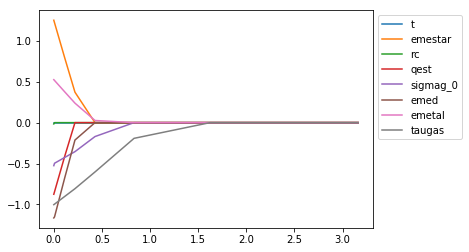

In [45]:
alph = logspace(-5,0.5, num=20)
coeffs = np.zeros((20, 8))
for i in range(len(alph)):
    a=alph[i]
    clf = linear_model.Lasso(alpha=a, tol=0.00001)
    clf.fit(Scale_high, num_planetas_high)
    coeffs[i]=clf.coef_ 
for i in range(len(coeffs[1,:])):
    plt.plot(alph,coeffs[:,i], label=labels[i])
plt.legend(bbox_to_anchor=(1., 1, 1., 0.), loc=2)

### Número de planetas - Low


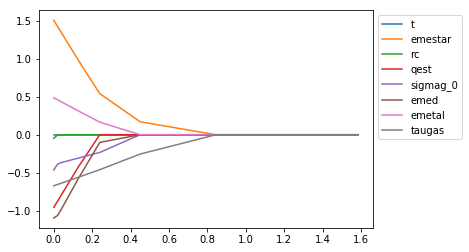

In [46]:
alph = logspace(-5,0.2, num=20)
coeffs = np.zeros((20, 8))
for i in range(len(alph)):
    a=alph[i]
    clf = linear_model.Lasso(alpha=a, tol=0.00001)
    clf.fit(Scale_low, num_planetas_low)
    coeffs[i]=clf.coef_ 
for i in range(len(coeffs[1,:])):
    plt.plot(alph,coeffs[:,i], label=labels[i])
plt.legend(bbox_to_anchor=(1., 1, 1., 0.), loc=2)

### Masa de planetas - High

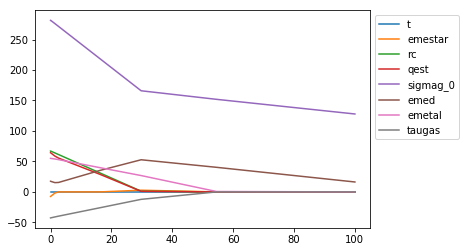

In [47]:
alph = logspace(-3,2, num=20)
coeffs = np.zeros((20, 8))
for i in range(len(alph)):
    a=alph[i]
    clf = linear_model.Lasso(alpha=a, tol=0.00001)
    clf.fit(Scale_high, masa_plan_high)
    coeffs[i]=clf.coef_ 
for i in range(len(coeffs[1,:])):
    plt.plot(alph,coeffs[:,i], label=labels[i])
plt.legend(bbox_to_anchor=(1., 1, 1., 0.), loc=2)

### Masa de planetas - Low


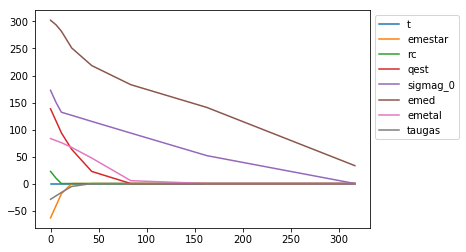

In [48]:
alph = logspace(-3,2.5, num=20)
coeffs = np.zeros((20, 8))
for i in range(len(alph)):
    a=alph[i]
    clf = linear_model.Lasso(alpha=a, tol=0.00001)
    clf.fit(Scale_low, masa_plan_low)
    coeffs[i]=clf.coef_ 
for i in range(len(coeffs[1,:])):
    plt.plot(alph,coeffs[:,i], label=labels[i])
plt.legend(bbox_to_anchor=(1., 1, 1., 0.), loc=2)

### Eficicencia de masa - High

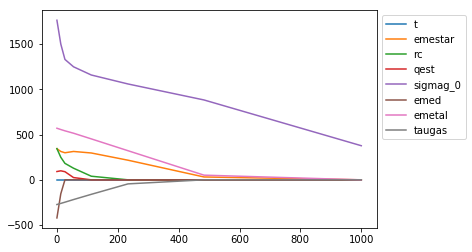

In [49]:
alph = logspace(-3,3, num=20)
coeffs = np.zeros((20, 8))
for i in range(len(alph)):
    a=alph[i]
    clf = linear_model.Lasso(alpha=a, tol=0.00001)
    clf.fit(Scale_high, efic_masa_high)
    coeffs[i]=clf.coef_ 
for i in range(len(coeffs[1,:])):
    plt.plot(alph,coeffs[:,i], label=labels[i])
plt.legend(bbox_to_anchor=(1., 1, 1., 0.), loc=2)

### Eficicencia de masa - Low

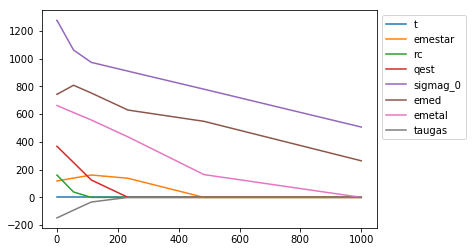

In [50]:
alph = logspace(-3,3, num=20)
coeffs = np.zeros((20, 8))
for i in range(len(alph)):
    a=alph[i]
    clf = linear_model.Lasso(alpha=a, tol=0.00001)
    clf.fit(Scale_low, efic_masa_low)
    coeffs[i]=clf.coef_ 
for i in range(len(coeffs[1,:])):
    plt.plot(alph,coeffs[:,i], label=labels[i])
plt.legend(bbox_to_anchor=(1., 1, 1., 0.), loc=2)